In [24]:
# 01 - Imports & paths

import os
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt

# ML utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# ALS (implicit feedback)
import implicit

# Item2Vec
from gensim.models import Word2Vec, KeyedVectors

# Sparse matrices
from scipy.sparse import coo_matrix

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("MODELS_DIR:", MODELS_DIR)


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
DATA_PROCESSED: C:\Users\Kiera\Music_Recommender\data\processed
MODELS_DIR: C:\Users\Kiera\Music_Recommender\models


In [25]:
# 02 - Load combined features, metadata, and interactions; intersect on track_id

FEATURES_PATH      = DATA_PROCESSED / "combined_features.csv"
INTERACTIONS_PATH  = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH    = DATA_PROCESSED / "track_metadata.csv"

# --- Load combined features ---
feat_df = pd.read_csv(FEATURES_PATH)
print("Features shape:", feat_df.shape)

# --- Load track metadata (for names, URIs, etc.) ---
meta_df = pd.read_csv(TRACK_META_PATH)
print("Track metadata shape:", meta_df.shape)

# --- Load interactions (pid, track_id, pos, duration_ms, ...) ---
inter_df = pd.read_parquet(INTERACTIONS_PATH)
print("Interactions shape:", inter_df.shape)

# Ensure track_id is string everywhere
for df_ in (feat_df, meta_df, inter_df):
    df_["track_id"] = df_["track_id"].astype(str)

# Keep only tracks that exist in all 3 (features + metadata + interactions)
track_ids_all = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
)

print("Tracks present in ALL (features+meta+interactions):", len(track_ids_all))

feat_df = feat_df[feat_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
meta_df = meta_df[meta_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
inter_df = inter_df[inter_df["track_id"].isin(track_ids_all)].reset_index(drop=True)

print("Filtered shapes:")
print("  features:", feat_df.shape)
print("  meta    :", meta_df.shape)
print("  inter   :", inter_df.shape)

# Simple metadata index for lookups (global)
meta_simple = (
    meta_df[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates()
    .set_index("track_id")
)


Features shape: (4589288, 17)
Track metadata shape: (679889, 7)
Interactions shape: (6685101, 4)
Tracks present in ALL (features+meta+interactions): 514672
Filtered shapes:
  features: (514672, 17)
  meta    : (514672, 7)
  inter   : (6175813, 4)


In [26]:
# 03 - Build numeric feature matrix + cosine KNN index (ALL intersection)

# Choose numeric feature columns (everything except ids / non-numerics)
non_feature_cols = {"track_id", "explicit"}  # explicit often messy / non-numeric
feature_cols = [
    c for c in feat_df.columns
    if c not in non_feature_cols and np.issubdtype(feat_df[c].dtype, np.number)
]

print("Feature columns used ({}):".format(len(feature_cols)))
print(feature_cols)

# Impute NaNs with column means
feat_mat = feat_df[feature_cols].copy()
feat_mat = feat_mat.fillna(feat_mat.mean())

# Standardise then L2-normalise rows
scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(feat_mat.values)

row_norms_all = np.linalg.norm(X_scaled_all, axis=1, keepdims=True)
row_norms_all[row_norms_all == 0.0] = 1.0
X_norm_all = X_scaled_all / row_norms_all

print("X_norm_all shape:", X_norm_all.shape)
print("Mean row norm (all):", float(np.linalg.norm(X_norm_all, axis=1).mean()))

# Track index mapping for feature space
track_ids_all_arr = feat_df["track_id"].values
tid_to_feat_idx_all = {tid: i for i, tid in enumerate(track_ids_all_arr)}

# Cosine KNN index (exact NN with brute-force cosine)
knn_cosine_all = NearestNeighbors(metric="cosine", algorithm="brute")
knn_cosine_all.fit(X_norm_all)

print("Built cosine KNN index on ALL intersection.")


Feature columns used (15):
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'year', 'time_signature', 'popularity']
X_norm_all shape: (514672, 15)
Mean row norm (all): 1.0
Built cosine KNN index on ALL intersection.


In [27]:
# 04 - Load Item2Vec (Word2Vec) model

item2vec_path = MODELS_DIR / "item2vec_word2vec.model"

if not item2vec_path.exists():
    raise FileNotFoundError(f"Item2Vec model not found at: {item2vec_path}")

print("Loading Item2Vec model from:", item2vec_path)

# Load full Word2Vec model
item2vec_model = Word2Vec.load(str(item2vec_path))

# We'll use the keyed vectors as our "track embedding" lookup
item2vec_kv = item2vec_model.wv

print("Item2Vec vocab size:", len(item2vec_kv.key_to_index))


Loading Item2Vec model from: C:\Users\Kiera\Music_Recommender\models\item2vec_word2vec.model
Item2Vec vocab size: 306873


In [28]:
# 05 - Hybrid track universe: tracks with features + meta + interactions + item2vec

track_universe = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
    & set(item2vec_kv.key_to_index.keys())
)

print("Track universe size (features+meta+inter+item2vec):", len(track_universe))

# Filter all three to this smaller, fully-covered universe
feat_df_u = feat_df[feat_df["track_id"].isin(track_universe)].reset_index(drop=True)
meta_df_u = meta_df[meta_df["track_id"].isin(track_universe)].reset_index(drop=True)
inter_df_u = inter_df[inter_df["track_id"].isin(track_universe)].reset_index(drop=True)

print("Filtered shapes (HYBRID universe):")
print("  features:", feat_df_u.shape)
print("  meta    :", meta_df_u.shape)
print("  inter   :", inter_df_u.shape)

# Rebuild feature matrix + scaling + normalisation on this universe
feat_mat_u = feat_df_u[feature_cols].copy()
feat_mat_u = feat_mat_u.fillna(feat_mat_u.mean())

scaler_u = StandardScaler()
X_scaled_u = scaler_u.fit_transform(feat_mat_u.values)

row_norms_u = np.linalg.norm(X_scaled_u, axis=1, keepdims=True)
row_norms_u[row_norms_u == 0.0] = 1.0
X_norm_u = X_scaled_u / row_norms_u

track_ids_u = feat_df_u["track_id"].values
tid_to_feat_idx_u = {tid: i for i, tid in enumerate(track_ids_u)}

knn_cosine_u = NearestNeighbors(metric="cosine", algorithm="brute")
knn_cosine_u.fit(X_norm_u)

print("Unified cosine index built on HYBRID universe.")


Track universe size (features+meta+inter+item2vec): 244370
Filtered shapes (HYBRID universe):
  features: (244370, 17)
  meta    : (244370, 7)
  inter   : (5905511, 4)
Unified cosine index built on HYBRID universe.


In [29]:
# 06 - Build ALS user–item matrix (on HYBRID universe) and train ALS

als_inter = inter_df_u.copy()

# Build integer ids for playlists + tracks
pid_codes = als_inter["pid"].astype("category")
tid_codes = als_inter["track_id"].astype("category")

als_inter["pid_idx"] = pid_codes.cat.codes
als_inter["tid_idx"] = tid_codes.cat.codes

n_users = als_inter["pid_idx"].nunique()
n_items = als_inter["tid_idx"].nunique()

print(f"ALS: n_users={n_users}, n_items={n_items}")

alpha = 1.0  # confidence scaling for implicit feedback
data = np.ones(len(als_inter), dtype=np.float32) * alpha
rows = als_inter["pid_idx"].values
cols = als_inter["tid_idx"].values

user_item_als = coo_matrix((data, (rows, cols)), shape=(n_users, n_items)).tocsr()

# Map ALS internal item index -> track_id
idx_to_tid_als = np.array(tid_codes.cat.categories)

# Train ALS (item × user)
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=10,
    random_state=42,
)
print("Fitting ALS on user_item_als...")
als_model.fit(user_item_als.T)
print("ALS training done.")

# Check dimensions & build a clean mapping
n_items_als = als_model.item_factors.shape[0]
print("ALS item_factors items:", n_items_als)

# Truncate idx_to_tid_als if needed (should match n_items_als)
if len(idx_to_tid_als) > n_items_als:
    print(f"Truncating idx_to_tid_als from {len(idx_to_tid_als)} to {n_items_als}")
    idx_to_tid_als = idx_to_tid_als[:n_items_als]

assert len(idx_to_tid_als) == n_items_als

# track_id -> ALS item index
tid_to_item_idx_als = {tid: i for i, tid in enumerate(idx_to_tid_als)}
print("Example ALS item mapping:", list(tid_to_item_idx_als.items())[:3])


ALS: n_users=99925, n_items=244370
Fitting ALS on user_item_als...


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.101837158203125 seconds
  warnings.warn(
100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

ALS training done.
ALS item_factors items: 99925
Truncating idx_to_tid_als from 244370 to 99925
Example ALS item mapping: [('00039MgrmLoIzSpuYKurn9', 0), ('000VZqvXwT0YNqKk7iG2GS', 1), ('000x2qE0ZI3hodeVrnJK8A', 2)]


In [30]:
# 07 - Cluster HYBRID-universe tracks in audio-feature space

N_CLUSTERS = 20

print(f"Clustering tracks with KMeans (K={N_CLUSTERS})...")
kmeans_tracks = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init="auto",
)
track_cluster_labels = kmeans_tracks.fit_predict(X_norm_u)
print("Track clustering complete.")

# Store cluster labels in a DataFrame for convenience
track_cluster_df = pd.DataFrame({
    "track_id": track_ids_u,
    "cluster_id": track_cluster_labels,
}).set_index("track_id")


Clustering tracks with KMeans (K=20)...
Track clustering complete.


In [31]:
# 08 - Helper functions: describe_tracks, search_tracks_by_name, get_cluster_id

def describe_tracks(track_ids, extra_cols=None, top_n=10):
    """
    Return metadata (and optional audio features) for given track_ids.
    Uses HYBRID-universe metadata and features.
    """
    track_ids = list(track_ids)

    # --- metadata ---
    meta_sub = (
        meta_df_u[["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .set_index("track_id")
        .loc[lambda df: df.index.intersection(track_ids)]
        .reset_index()
    )

    # --- optional audio features ---
    if extra_cols:
        feat_idx = feat_df_u.set_index("track_id")
        common_ids = feat_idx.index.intersection(track_ids)
        feat_sub = feat_idx.loc[common_ids, extra_cols].reset_index()
        meta_sub = meta_sub.merge(feat_sub, on="track_id", how="left")

    if top_n is not None:
        meta_sub = meta_sub.head(top_n)

    return meta_sub


def search_tracks_by_name(query, max_results=10):
    """
    Simple case-insensitive substring search over track_name in HYBRID universe.
    """
    q = query.lower()
    hits = (
        meta_df_u
        .loc[meta_df_u["track_name"].str.lower().str.contains(q, na=False),
             ["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .head(max_results)
    )
    return hits


def get_cluster_id(track_id):
    """
    Return cluster_id for a track_id, or None if not clustered.
    """
    try:
        return int(track_cluster_df.loc[track_id, "cluster_id"])
    except KeyError:
        return None


In [32]:
# 09 - Hybrid config: neighbour counts & candidate pool

# How many neighbours we ask from each individual model
COS_TOPN   = 1000   # cosine neighbours in feature space
ALS_TOPN   = 1000   # ALS similar items
I2V_TOPN   = 1000   # item2vec neighbours

# Cap on the final union of candidates before scoring
HYBRID_CANDIDATE_POOL = 2000


In [33]:
# 10 - Single-model scorers: cosine, ALS, item2vec


def cosine_scores_for_track(track_id, top_n=COS_TOPN):
    """
    Get cosine-similar tracks in feature space for a given track_id.
    Returns a DataFrame: [track_id, cosine_sim]
    """
    if track_id not in tid_to_feat_idx_u:
        return pd.DataFrame(columns=["track_id", "cosine_sim"])
    
    idx = tid_to_feat_idx_u[track_id]
    vec = X_norm_u[idx : idx + 1]

    # +1 to include the seed; we'll drop it
    distances, indices = knn_cosine_u.kneighbors(vec, n_neighbors=top_n + 1)
    distances = distances[0]
    indices = indices[0]

    sims = 1.0 - distances  # cosine similarity

    neigh_tids = track_ids_u[indices]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "cosine_sim": sims,
    })
    # drop self
    df = df[df["track_id"] != track_id].reset_index(drop=True)
    return df


def als_scores_for_track(track_id, top_n=ALS_TOPN):
    """
    Get ALS similar-item scores for a given track_id.
    Returns: [track_id, als_sim]
    """
    if track_id not in tid_to_item_idx_als:
        # This track has no ALS item factors
        return pd.DataFrame(columns=["track_id", "als_sim"])

    item_idx = tid_to_item_idx_als[track_id]
    n_items_als = als_model.item_factors.shape[0]
    if not (0 <= item_idx < n_items_als):
        # out of range for some reason -> treat as no ALS signal
        return pd.DataFrame(columns=["track_id", "als_sim"])

    sim_items, sim_scores = als_model.similar_items(
        itemid=item_idx,
        N=top_n + 1,   # include self
    )

    neigh_tids = idx_to_tid_als[sim_items]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "als_sim": sim_scores,
    })

    # Drop the seed track itself
    df = df[df["track_id"] != track_id].reset_index(drop=True)

    return df.head(top_n)


def item2vec_scores_for_track(track_id, top_n=I2V_TOPN):
    """
    Get item2vec neighbours for a given track_id.
    Returns: [track_id, item2vec_sim]
    """
    if track_id not in item2vec_kv:
        return pd.DataFrame(columns=["track_id", "item2vec_sim"])
    
    most_sim = item2vec_kv.most_similar(track_id, topn=top_n + 1)

    neigh_tids = []
    neigh_scores = []
    for tid, score in most_sim:
        if tid == track_id:
            continue
        neigh_tids.append(tid)
        neigh_scores.append(score)
        if len(neigh_tids) >= top_n:
            break

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "item2vec_sim": neigh_scores,
    })
    return df


In [ ]:
# 11 - Hybrid scores: union of candidates + recompute full scores for each model


def hybrid_scores_for_track(
    track_id,
    w_cos=0.3,
    w_als=0.3,
    w_i2v=0.3,
    w_cluster=0.05,        # smaller default cluster weight
    top_k=30,
    candidate_pool=HYBRID_CANDIDATE_POOL,
    verbose=True,
):
    """
    Compute hybrid scores for neighbours of a single seed track.

    KEY CHANGE vs previous version:
    -------------------------------
    - We still build a candidate set from the union of:
        * cosine neighbours
        * ALS similar-items
        * item2vec neighbours
      (this gives a diverse set of plausible candidates)
    - BUT then we RECOMPUTE all three similarities for EVERY candidate
      wherever possible:

        cosine_sim   -> always defined for tracks with features (HYBRID universe)
        als_sim      -> defined if both seed & candidate have ALS factors
        item2vec_sim -> defined if both seed & candidate are in item2vec vocab

      So NaNs now mean "this model truly has no signal for this track",
      not "we didn't happen to fetch it in the top-N list".

    Returns a DataFrame with:
      [track_id, cosine_sim, als_sim, item2vec_sim, same_cluster, hybrid_score]
    """

    # ---------- 1. Build initial candidate set from all three models ----------

    df_cos = cosine_scores_for_track(track_id, top_n=COS_TOPN)
    df_als = als_scores_for_track(track_id, top_n=ALS_TOPN)
    df_i2v = item2vec_scores_for_track(track_id, top_n=I2V_TOPN)

    # Outer merge = union of all candidates
    df = (
        df_cos
        .merge(df_als, on="track_id", how="outer")
        .merge(df_i2v, on="track_id", how="outer")
    )

    # Drop seed if it appears
    df = df[df["track_id"] != track_id].reset_index(drop=True)

    if df.empty:
        if verbose:
            print(f"No candidates from any model for seed {track_id}")
        return df.assign(
            same_cluster=pd.Series(dtype=float),
            hybrid_score=pd.Series(dtype=float),
        )

    # If too many candidates, keep those with the largest max raw score
    if len(df) > candidate_pool:
        df["max_raw_score"] = df[["cosine_sim", "als_sim", "item2vec_sim"]].max(axis=1, skipna=True)
        df = df.sort_values("max_raw_score", ascending=False).head(candidate_pool).reset_index(drop=True)
        df = df.drop(columns=["max_raw_score"])

    # We now have a candidate list. We'll overwrite cosine_sim / als_sim / item2vec_sim
    candidate_ids = df["track_id"].tolist()

    # ---------- 2. Recompute cosine_sim for ALL candidates (where possible) ----------

    cos_vals = []
    if track_id in tid_to_feat_idx_u:
        seed_idx = tid_to_feat_idx_u[track_id]
        seed_vec = X_norm_u[seed_idx]
        for tid in candidate_ids:
            idx = tid_to_feat_idx_u.get(tid)
            if idx is None:
                cos_vals.append(np.nan)
            else:
                cand_vec = X_norm_u[idx]
                # dot of L2-normalised vectors = cosine similarity
                cos_vals.append(float(np.dot(seed_vec, cand_vec)))
    else:
        # seed not in feature space (shouldn't happen in HYBRID universe),
        # but handle gracefully
        cos_vals = [np.nan] * len(candidate_ids)

    df["cosine_sim"] = pd.Series(cos_vals, index=df.index, dtype="float64")

    # ---------- 3. Recompute ALS similarity for ALL candidates (where possible) ----------

    als_vals = []
    if track_id in tid_to_item_idx_als:
        seed_item_idx = tid_to_item_idx_als[track_id]
        seed_vec = als_model.item_factors[seed_item_idx]
        for tid in candidate_ids:
            cand_idx = tid_to_item_idx_als.get(tid)
            if cand_idx is None:
                als_vals.append(np.nan)
            else:
                cand_vec = als_model.item_factors[cand_idx]
                # Simple dot product in latent space
                als_vals.append(float(np.dot(seed_vec, cand_vec)))
    else:
        als_vals = [np.nan] * len(candidate_ids)

    df["als_sim"] = pd.Series(als_vals, index=df.index, dtype="float64")

    # ---------- 4. Recompute item2vec similarity for ALL candidates (where possible) ----------

    i2v_vals = []
    has_seed_i2v = track_id in item2vec_kv.key_to_index
    for tid in candidate_ids:
        if not has_seed_i2v or tid not in item2vec_kv.key_to_index:
            i2v_vals.append(np.nan)
        else:
            # gensim KeyedVectors already stores normalised vectors, so this is cosine
            i2v_vals.append(float(item2vec_kv.similarity(track_id, tid)))

    df["item2vec_sim"] = pd.Series(i2v_vals, index=df.index, dtype="float64")

    # ---------- 5. Coverage diagnostics (AFTER recompute) ----------

    if verbose:
        n_cand = len(df)
        cov_cos = df["cosine_sim"].notna().mean() if n_cand else 0.0
        cov_als = df["als_sim"].notna().mean() if n_cand else 0.0
        cov_i2v = df["item2vec_sim"].notna().mean() if n_cand else 0.0
        print(
            f"[COVERAGE] seed={track_id}, candidates={n_cand}, "
            f"cosine={cov_cos:.1%}, ALS={cov_als:.1%}, item2vec={cov_i2v:.1%}"
        )

    # ---------- 6. Same-cluster flag ----------

    seed_cluster = get_cluster_id(track_id)
    df["same_cluster"] = df["track_id"].apply(
        lambda tid: 1.0 if (seed_cluster is not None and get_cluster_id(tid) == seed_cluster) else 0.0
    )

    # ---------- 7. Min–max normalise each model's scores over candidates ----------

    def col_minmax_numeric(series):
        # ensure numeric float dtype to avoid FutureWarning
        series = pd.to_numeric(series, errors="coerce")
        if series.notna().sum() == 0:
            return series.astype("float64")
        cmin = series.min(skipna=True)
        cmax = series.max(skipna=True)
        if cmax == cmin:
            # all same -> treat as 1.0 where present
            return series.notna().astype(float)
        return (series - cmin) / (cmax - cmin)

    df["cosine_norm"]   = col_minmax_numeric(df["cosine_sim"])
    df["als_norm"]      = col_minmax_numeric(df["als_sim"])
    df["item2vec_norm"] = col_minmax_numeric(df["item2vec_sim"])

    # ---------- 8. Per-track weight renormalisation (only models that actually have signal) ----------

    cos_present = df["cosine_norm"].notna().astype(float)
    als_present = df["als_norm"].notna().astype(float)
    i2v_present = df["item2vec_norm"].notna().astype(float)

    eff_cos_w = w_cos * cos_present
    eff_als_w = w_als * als_present
    eff_i2v_w = w_i2v * i2v_present

    weight_sum = eff_cos_w + eff_als_w + eff_i2v_w

    valid_mask = weight_sum > 0
    df = df[valid_mask].copy()
    eff_cos_w = eff_cos_w[valid_mask]
    eff_als_w = eff_als_w[valid_mask]
    eff_i2v_w = eff_i2v_w[valid_mask]
    weight_sum = weight_sum[valid_mask]

    # Normalised weights per track
    w_cos_norm = eff_cos_w / weight_sum
    w_als_norm = eff_als_w / weight_sum
    w_i2v_norm = eff_i2v_w / weight_sum

    # Replace NaNs with 0.0 for multiplication
    df["cosine_norm"]   = pd.to_numeric(df["cosine_norm"], errors="coerce").fillna(0.0)
    df["als_norm"]      = pd.to_numeric(df["als_norm"], errors="coerce").fillna(0.0)
    df["item2vec_norm"] = pd.to_numeric(df["item2vec_norm"], errors="coerce").fillna(0.0)

    base_hybrid = (
        w_cos_norm.to_numpy() * df["cosine_norm"].to_numpy()
        + w_als_norm.to_numpy() * df["als_norm"].to_numpy()
        + w_i2v_norm.to_numpy() * df["item2vec_norm"].to_numpy()
    )

    # Cluster bonus as a small bump, not a sledgehammer
    df["hybrid_score"] = base_hybrid + w_cluster * df["same_cluster"].to_numpy()

    # ---------- 9. Final tidy-up ----------

    keep_cols = [
        "track_id",
        "cosine_sim", "als_sim", "item2vec_sim",
        "same_cluster",
        "hybrid_score",
    ]
    df = df[keep_cols].sort_values("hybrid_score", ascending=False).reset_index(drop=True)

    return df.head(top_k)


In [35]:
# 12 - User-facing helper: recommend_by_name_hybrid + demo examples


def recommend_by_name_hybrid(
    query,
    candidate_index=0,
    w_cos=0.3,
    w_als=0.3,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=20,
    candidate_pool=HYBRID_CANDIDATE_POOL,
):
    """
    Convenience wrapper:
      - fuzzy search by track_name within HYBRID universe
      - pick one candidate by index
      - compute hybrid recommendations
      - attach metadata + audio features
    """

    # --- 1. search ---
    hits = search_tracks_by_name(query, max_results=10)
    if hits.empty:
        print(f"No matches for query '{query}'")
        return None, pd.DataFrame()

    print("Search results:")
    display(hits.reset_index(drop=True))

    if candidate_index >= len(hits):
        raise ValueError(f"candidate_index {candidate_index} out of range for {len(hits)} results")

    seed_row = hits.iloc[candidate_index]
    seed_tid = seed_row["track_id"]

    print("\nChosen seed track:")
    display(seed_row.to_frame().T)

    # --- 2. hybrid scores ---
    df_scores = hybrid_scores_for_track(
        seed_tid,
        w_cos=w_cos,
        w_als=w_als,
        w_i2v=w_i2v,
        w_cluster=w_cluster,
        top_k=top_k,
        candidate_pool=candidate_pool,
        verbose=True,
    )

    if df_scores.empty:
        print("No hybrid candidates found.")
        return seed_row, df_scores

    # --- 3. attach metadata + a few audio features ---
    rec_df = describe_tracks(
        df_scores["track_id"].tolist(),
        extra_cols=["danceability", "energy", "valence", "tempo"],
        top_n=None,
    )

    rec_df = rec_df.merge(df_scores, on="track_id", how="left")
    rec_df = rec_df.sort_values("hybrid_score", ascending=False).reset_index(drop=True)

    print("\nHybrid recommendations:")
    display(rec_df.head(top_k))

    return seed_row, rec_df


# --- Demo examples for 5 seed songs ---

# Example 1: Pitbull "Hotel Room Service"
seed1, recs1 = recommend_by_name_hybrid(
    "hotel room service",
    candidate_index=0,
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 2: Billie Eilish "ocean eyes"
seed2, recs2 = recommend_by_name_hybrid(
    "ocean eyes",
    candidate_index=1,  # original track on dont smile at me (adjust if needed)
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 3: Travis Scott "90210"
seed3, recs3 = recommend_by_name_hybrid(
    "90210",
    candidate_index=5,  # Travis Scott "90210" (adjust if search order changes)
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 4: Beatles "Yesterday - Remastered"
seed4, recs4 = recommend_by_name_hybrid(
    "yesterday - remastered",
    candidate_index=0,
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 5: Kanye West "Gold Digger"
seed5, recs5 = recommend_by_name_hybrid(
    "gold digger",
    candidate_index=3,  # Kanye "Gold Digger" (adjust if search order changes)
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)


Search results:


,track_id,track_name,artist_name,album_name
0,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
1,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
12597,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution


[COVERAGE] seed=0OPyDgTRuIdCJ9B4bYSths, candidates=2000, cosine=50.0%, ALS=2.9%, item2vec=49.9%

Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,1jlKdNbOA90rjnt88GJnwO,La Vuelta Al Mundo,Calle 13,Entren Los Que Quieran,0.748,0.538,0.779,124.974,0.962181,NaN,NaN,1.0,1.100000
1,4X5f3vT8MRuXF68pfjNte5,F**kin' Problems,A$AP Rocky,LONG.LIVE.A$AP (Deluxe Version),0.853,0.693,0.662,95.967,0.956908,NaN,NaN,1.0,1.073364
2,13plQdOoWSSXPRUSZc5FuM,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,0.817,0.733,0.833,127.056,0.958954,NaN,0.875651,1.0,1.057901
3,2jFglF0pDwhrrXmeWZvmKY,Te amo,Alexander Acha,Voy,0.533,0.559,0.284,136.037,NaN,0.795610,NaN,1.0,1.039265
4,0tm6gsXe0LSm9zeSspyMQu,Rapper's Delight - Single Version,The Sugarhill Gang,The Sugarhill Gang - 30th Anniversary Edition,0.917,0.692,0.819,111.782,0.948802,NaN,NaN,1.0,1.032417
5,3rfhI32Il2hVRKDkuGeeen,Hey Baby (Drop It To the Floor),Pitbull,Planet Pit (Deluxe Version),0.595,0.912,0.762,128.024,NaN,NaN,0.873172,1.0,1.026255
6,0CAfXk7DXMnon4gLudAp7J,Low (feat T-Pain) - Feat T-Pain Album Version,Flo Rida,Mail On Sunday,0.918,0.609,0.304,128.008,NaN,NaN,0.870668,1.0,1.011665
7,7wBThXx7BGZHJJ3aN3OPvv,Confessions Part II - Confessions Special Edit...,Usher,Confessions,0.845,0.467,0.702,138.007,0.943450,NaN,NaN,1.0,1.005381
8,4sNUtmv7qaDW7cl855T4Ae,Drop It Like It's Hot,Eclipse,Renee Graziano's Mob Candy Made Men of Hip Hop,0.916,0.557,0.362,92.062,NaN,NaN,0.885828,0.0,1.000000
9,07Wl6mcRyN0ov49w39to7B,Flight of the Bumble Bee,Nikolai Rimsky-Korsakov,Kids Orchestral Music for Play & Relaxation,0.271,0.152,0.283,179.390,NaN,0.816255,NaN,0.0,1.000000


Search results:


,track_id,track_name,artist_name,album_name
0,1JbuC7uZm0P1PyX7N7gDEM,Ocean Eyes - GOLDHOUSE Remix,Billie Eilish,Ocean Eyes
1,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me
2,3bM4b4P6QFDnjdXXI2zufO,Ocean Eyes - Cautious Clay Remix,Billie Eilish,Ocean Eyes
3,4JuZQeSRYJfLCqBgBIxxrR,Ocean Eyes - Blackbear Remix,Billie Eilish,Ocean Eyes
4,6NOq79ynBpBi6BSJMdgReN,Ocean Eyes - Astronomyy Remix,Billie Eilish,Ocean Eyes



Chosen seed track:


,track_id,track_name,artist_name,album_name
106956,3OMh7VdOoWgtKhJimQQywz,ocean eyes,Billie Eilish,dont smile at me


[COVERAGE] seed=3OMh7VdOoWgtKhJimQQywz, candidates=1973, cosine=50.7%, ALS=0.0%, item2vec=50.7%


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\937369211.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["als_norm"]      = df["als_norm"].fillna(0.0)



Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0xIubWgTBUCYZs8W743aH4,Cassie - Acoustic,Flyleaf,Flyleaf,0.540,0.341,0.1780,151.968,0.984425,NaN,NaN,1.0,1.100000
1,3zHtfZiBbOZx6QwNZAaypA,Some Things Just Stick in Your Mind,The Sweeplings,"Covers, Ch. 1",0.488,0.379,0.1050,134.131,0.977875,NaN,NaN,1.0,1.068122
2,1UWmxGZLO8O8LTZQcYjMx2,Chains,The Sweeplings,"Covers, Ch. 1",0.547,0.326,0.2180,130.073,0.964332,NaN,NaN,1.0,1.002207
3,5hWZSnDyQSdydBWrZnVX9Z,Be Your Sound - Live Acoustic Version,Cosmic Gate,Starting Fires (Acoustic EP),0.456,0.368,0.2450,133.641,0.964307,NaN,NaN,1.0,1.002087
4,2VlLbhGLVJgdOW7kKdWWFc,Six Feet Under,Billie Eilish,Six Feet Under,0.576,0.307,0.1570,67.513,NaN,NaN,0.894866,0.0,1.000000
5,2L6PBQNZDLprugdpx0Cm9t,Wait For Me,Anaïs Mitchell,Hadestown,0.562,0.464,0.1630,156.298,0.961496,NaN,NaN,1.0,0.988409
6,51ffA19CWmzNenet0aeTmW,What Makes a Man,City and Colour,The MySpace Transmissions,0.453,0.307,0.2970,141.359,0.961408,NaN,NaN,1.0,0.987979
7,6OVsn2uURKTLIguCDxgNWS,Break the Silence,Francois Mulder,Break the Silence,0.449,0.403,0.2480,153.617,0.960411,NaN,NaN,1.0,0.983124
8,6hNl32drRtwGZaJ0iutWj2,A Part Of That,Anna Kendrick,The Last Five Years,0.390,0.343,0.1690,139.667,0.959504,NaN,NaN,1.0,0.978710
9,4CR9jyIPZ2kP72RetFm79A,Where Is Grace,Ascend The Hill,O Ransomed Son,0.477,0.234,0.1540,129.598,0.957468,NaN,NaN,1.0,0.968802


Search results:


,track_id,track_name,artist_name,album_name
0,14hMPAYT3yRC73RREe88UL,90210,The Courtneys,The Courtneys
1,2mZF9Se9RWzjxK6EnXvIZG,90210,blackbear,Dead
2,3k1ykgOj81yLOHKPmklHeV,90210,Wale,Attention Deficit
3,4buyECQgJ5HIM457t7d5J2,How Do You Talk To An Angel (As Heard on Bever...,Jamie Walters & The Heights,Modern Rock - Sound Of The 90s & 00s Alternati...
4,4hdog9vyyqG9pcppG2Izek,90210 (feat. G-Eazy),blackbear,Deadroses
5,51EC3I1nQXpec4gDk0mQyP,90210,Travis Scott,Rodeo



Chosen seed track:


,track_id,track_name,artist_name,album_name
157796,51EC3I1nQXpec4gDk0mQyP,90210,Travis Scott,Rodeo


[COVERAGE] seed=51EC3I1nQXpec4gDk0mQyP, candidates=1982, cosine=50.5%, ALS=0.0%, item2vec=50.5%


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\937369211.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["als_norm"]      = df["als_norm"].fillna(0.0)



Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,0IabpxMpUV7waD7U4uDIMJ,Impossible,Travis Scott,Rodeo,0.507,0.464,0.2770,147.984,NaN,NaN,0.908414,1.0,1.100000
1,5M4yti0QxgqJieUYaEXcpw,Eventually,Tame Impala,Currents,0.424,0.615,0.1550,77.935,0.964880,NaN,NaN,1.0,1.100000
2,1UGD3lW3tDmgZfAVDh6w7r,Devil In A New Dress,Kanye West,My Beautiful Dark Twisted Fantasy,0.435,0.760,0.2060,80.082,0.964069,NaN,NaN,1.0,1.096228
3,2rMFawCg4BW65jzbwztXAV,Oh My Dis Side,Travis Scott,Rodeo,0.459,0.623,0.2050,126.018,NaN,NaN,0.906737,1.0,1.091174
4,6scpNkWEmUxmKY7nYjVLsX,Apple Pie,Travis Scott,Rodeo,0.655,0.496,0.2800,137.945,NaN,NaN,0.902438,1.0,1.068538
5,3dtBVBClM5ms0qCBBrqpUb,Wasted,Travis Scott,Rodeo,0.689,0.610,0.1190,134.923,NaN,NaN,0.892265,1.0,1.014982
6,2hiuiI3ac0I5kJWtkeGHEL,I Can Tell,Travis Scott,Rodeo,0.696,0.800,0.0635,110.013,NaN,NaN,0.891513,1.0,1.011024
7,4B1rpPmQXwj78wk6aIGwwU,Two Ghosts,Harry Styles,Harry Styles,0.386,0.407,0.4560,69.387,0.938385,NaN,NaN,1.0,0.976790
8,0MRZ9nMoLc7qQ8Nhovv8C8,Ok Alright,Travis Scott,Rodeo,0.530,0.661,0.1490,122.482,NaN,NaN,0.884804,1.0,0.975702
9,7eqoqGkKwgOaWNNHx90uEZ,Nights,Frank Ocean,Blonde,0.457,0.551,0.4280,89.870,0.931341,NaN,NaN,1.0,0.944030


Search results:


,track_id,track_name,artist_name,album_name
0,1e0hllQ23AG0QGFgezgLOq,Yesterday - Remastered,The Beatles,Help!



Chosen seed track:


,track_id,track_name,artist_name,album_name
52087,1e0hllQ23AG0QGFgezgLOq,Yesterday - Remastered,The Beatles,Help!


[COVERAGE] seed=1e0hllQ23AG0QGFgezgLOq, candidates=2000, cosine=50.0%, ALS=7.8%, item2vec=42.9%

Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,3zgkdaE75q2K2Uuy3PttZa,Silent Night,Gene Autry,The Original: Gene Autry Sings Rudolph The Red...,0.202,0.167,0.2120,85.411,0.982240,NaN,NaN,1.0,1.100000
1,5V1AHQugSTASVez5ffJtFo,Let It Be - Remastered,The Beatles,Let It Be,0.443,0.403,0.4100,143.462,NaN,NaN,0.939063,1.0,1.100000
2,0huDTnkXO0LJZcAHjotWYz,"Winnie The Pooh - From ""Winnie the Pooh and th...",Disney Studio Chorus,Disney Classics,0.329,0.158,0.2060,79.585,0.979884,NaN,NaN,1.0,1.078242
3,0CMUzgMnyoO5x3Z9xuCYxS,Great Fairy Fountain,Taylor Davis,"Melodies of Hyrule: Music from ""The Legend of ...",0.207,0.315,0.0867,159.615,NaN,0.971240,NaN,1.0,1.053258
4,2I5GGrUkhtl4RvSz7PZIpQ,30 Century Man,Scott Walker,Scott 3,0.500,0.132,0.5150,85.650,NaN,0.948163,NaN,1.0,1.004025
5,31ztBixpD4V52G3Rjnnqhz,Queen Of Saint Mary’s Choir,Sean McConnell,Sean McConnell,0.524,0.511,0.6650,164.024,NaN,0.993150,NaN,0.0,1.000000
6,120AzdF19aZuBhrGCakWpw,Shapeshifters,Hands Like Houses,Unimagine,0.349,0.958,0.6800,178.056,NaN,0.990840,NaN,0.0,0.995072
7,0odgoLuCmmPCtsG0D3sZyd,The Flim Flam Cider Song,Flim,Songs of Friendship and Magic (Music from the ...,0.736,0.716,0.8330,117.975,NaN,0.989707,NaN,0.0,0.992654
8,1uSPQKYTtRKZM1U3ipzIKH,Village of Love,The Detroit Cobras,The Original Recordings,0.644,0.706,0.8460,136.239,NaN,0.989472,NaN,0.0,0.992152
9,23LZ1IA37NSybPbvPi5YCP,I Claim Your Sun,Steve Jablonsky,Transformers: Revenge Of The Fallen - The Score,0.224,0.556,0.0719,138.289,NaN,0.989076,NaN,0.0,0.991308


Search results:


,track_id,track_name,artist_name,album_name
0,0KYIiOHyUc4Nas7vJdIC8p,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Music of K...
1,14RcvIro4H3ZzLMOVUopij,Gold Digger,Vitamin String Quartet,Vitamin String Quartet Performs the Songs from...
2,1M1DkiVCJ7KURGMkSXrZKh,Gold Digger,EPMD,Business As Usual
3,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration
4,6PgLf0yuB11BOysPAbrxPC,Gold Digger,Xavier Dunn,BIMYOU
5,7x1cPQLMzaKknLtdAU59dc,Gold Digger (Glee Cast Version),Glee Cast,"Glee: The Music, Volume 1"



Chosen seed track:


,track_id,track_name,artist_name,album_name
173899,5XJJdNPkwmbUwE79gv0NxK,Gold Digger,Kanye West,Late Registration


[COVERAGE] seed=5XJJdNPkwmbUwE79gv0NxK, candidates=1986, cosine=50.4%, ALS=0.0%, item2vec=50.4%


C:\Users\Kiera\AppData\Local\Temp\ipykernel_32512\937369211.py:115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["als_norm"]      = df["als_norm"].fillna(0.0)



Hybrid recommendations:


,track_id,track_name,artist_name,album_name,danceability,energy,valence,tempo,cosine_sim,als_sim,item2vec_sim,same_cluster,hybrid_score
0,1rDamogWkzMgTLxv7eb5Ut,Copycat (feat. Fashawn),20syl,Motifs II - EP,0.613,0.702,0.524,86.987,0.976561,NaN,NaN,1.0,1.100000
1,5UT8S5wbRGVpuwqEcvY80D,Sugar,Atmosphere,Fishing Blues,0.679,0.648,0.624,83.966,0.971295,NaN,NaN,1.0,1.067940
2,4eTjhDsNCkh2nsxDeJL8ew,"Ride Wit Me (feat. Meek Mill, T.I.)",Trae Tha Truth,I Am King,0.709,0.768,0.622,109.907,0.969923,NaN,NaN,1.0,1.059586
3,6MzwNRu9TDbHoNsry5axi5,Walk In,Lil Wayne,Tha Carter,0.726,0.708,0.834,73.981,0.965799,NaN,NaN,1.0,1.034477
4,3rMYpDSp6Sj9dhBM1QhNy9,You,Z-Ro,Crack,0.720,0.651,0.504,79.098,0.964205,NaN,NaN,1.0,1.024772
5,2a6lfiEI9dstu6NUSE3FPw,Liberal Opposer,Kabaka Pyramid,Lead The Way,0.719,0.794,0.523,92.112,0.963343,NaN,NaN,1.0,1.019522
6,49h4LyedeD1K6irNl7RnCW,Get Me Some,J. Stalin,On Behalf of the Streets 2,0.824,0.722,0.728,95.963,0.962754,NaN,NaN,1.0,1.015935
7,0NaL5rj4VAuEYEuQsk7thM,"Superman, The Gift And The Curse",Jon Bellion,The Separation,0.627,0.667,0.579,83.663,0.962373,NaN,NaN,1.0,1.013614
8,5cBq5FFxKDajcPOJJk9BZr,Right Now,Mary J. Blige,The London Sessions,0.713,0.778,0.527,106.108,0.961292,NaN,NaN,1.0,1.007037
9,2d9B8oSTdsU58y8o3j9VBc,Life 101 (feat. Chris Lee),Trip Lee,Between Two Worlds,0.489,0.751,0.582,90.057,0.961257,NaN,NaN,1.0,1.006823


In [36]:
# 13 - PCA on a sample of tracks for 2D visualisation

N_SAMPLE = 20000
rng = np.random.default_rng(42)

idx_sample = rng.choice(X_norm_u.shape[0], size=min(N_SAMPLE, X_norm_u.shape[0]), replace=False)
X_sample = X_norm_u[idx_sample]
tids_sample = track_ids_u[idx_sample]
clusters_sample = track_cluster_labels[idx_sample]

pca = PCA(n_components=2, random_state=42)
X_pca_sample = pca.fit_transform(X_sample)

pca_df = pd.DataFrame({
    "x": X_pca_sample[:, 0],
    "y": X_pca_sample[:, 1],
    "track_id": tids_sample,
    "cluster_id": clusters_sample,
}).set_index("track_id")

print("PCA sample shape:", pca_df.shape)


PCA sample shape: (20000, 3)


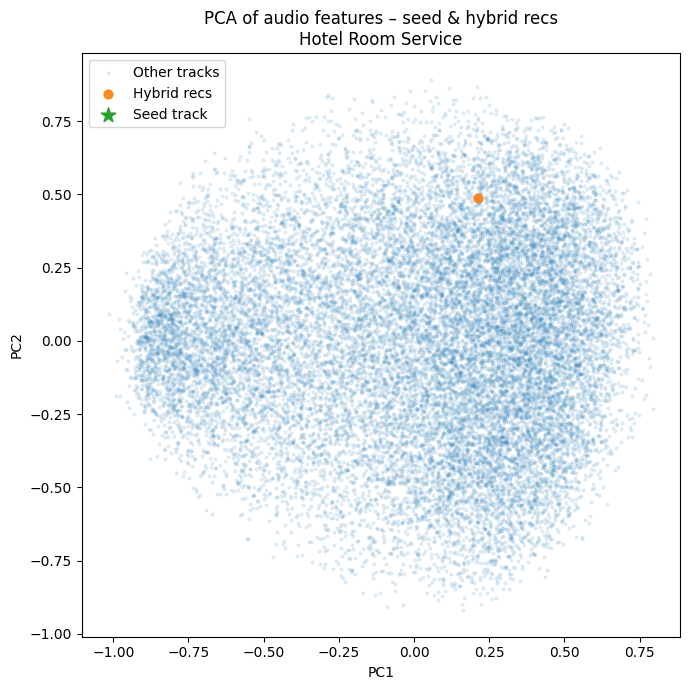

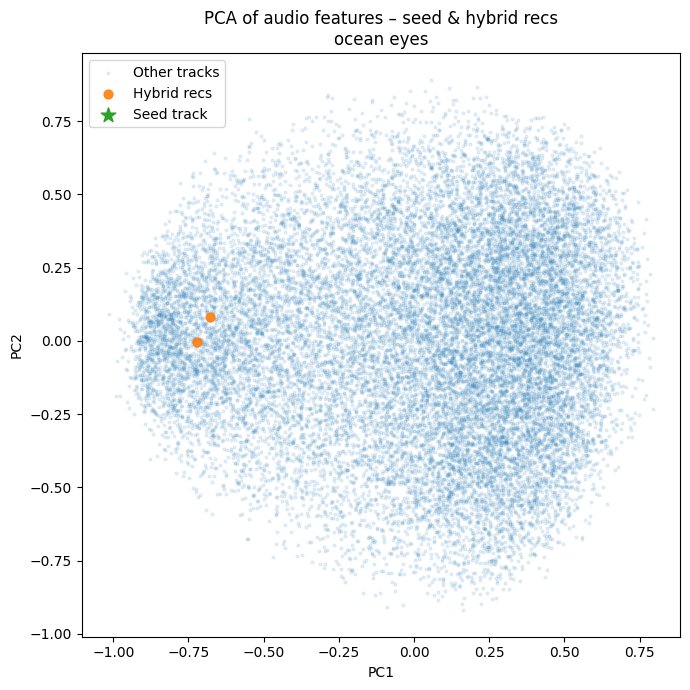

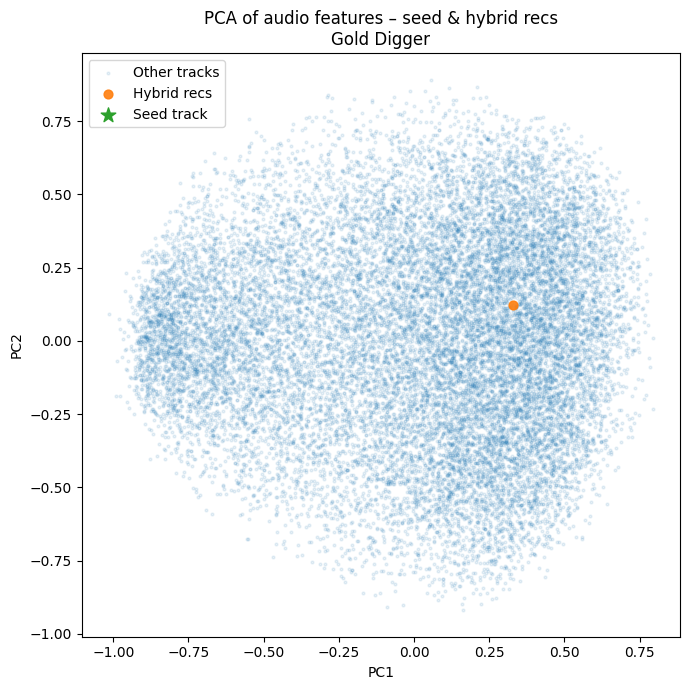

In [37]:
# 14 - Visual helper: plot seed + hybrid recommendations in PCA space

def plot_seed_and_recs_on_pca(seed_row, rec_df, title_suffix=""):
    seed_tid = seed_row["track_id"]

    rec_ids = rec_df["track_id"].tolist()
    all_ids = [seed_tid] + rec_ids

    df = pca_df.loc[pca_df.index.intersection(all_ids)].copy()
    if df.empty:
        print("Seed + recs not found in PCA sample (downsampling issue).")
        return

    df["is_seed"] = (df.index == seed_tid)

    plt.figure(figsize=(7, 7))

    # Background: all sampled tracks (faint)
    plt.scatter(
        pca_df["x"],
        pca_df["y"],
        s=4,
        alpha=0.1,
        label="Other tracks",
    )

    # Recommendations
    rec_mask = ~df["is_seed"]
    plt.scatter(
        df.loc[rec_mask, "x"],
        df.loc[rec_mask, "y"],
        s=40,
        alpha=0.9,
        label="Hybrid recs",
    )

    # Seed
    plt.scatter(
        df.loc[df["is_seed"], "x"],
        df.loc[df["is_seed"], "y"],
        s=120,
        marker="*",
        label="Seed track",
    )

    plt.title(f"PCA of audio features – seed & hybrid recs\n{title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example visualisations
if seed1 is not None and not recs1.empty:
    plot_seed_and_recs_on_pca(seed1, recs1, title_suffix=seed1["track_name"])
if seed2 is not None and not recs2.empty:
    plot_seed_and_recs_on_pca(seed2, recs2, title_suffix=seed2["track_name"])
if seed5 is not None and not recs5.empty:
    plot_seed_and_recs_on_pca(seed5, recs5, title_suffix=seed5["track_name"])
